# Dec 23rd, 2022 (Parc: subctx, render)

**Motivation**: Take the newly defined whole-brain parcellation and render results.  Do they look reasonable? <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
fig_dir = pjoin(fig_base_dir, 'parcellation', 'render')
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render

## Prepare

In [3]:
mice = Mice(128, load_allen=True, load_parcel=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
masks = {
    acro: mice.al.get_masks(acro) for
    acro in mice.al.get_major_12()
}

## Redner

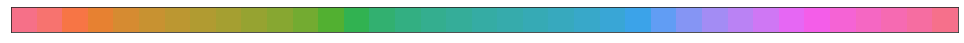

In [5]:
sys.path.insert(0, pjoin(git_dir, 'vedo'))
sys.path.insert(0, pjoin(git_dir, 'brainrender'))

from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume
from register.atlas import load_bg_atlas

cmap = sns.color_palette('husl', as_cmap=True)
display_cmap(cmap)

### Save cortical + subcortical

In [6]:
%%time

for acro, m in masks.items():
    # get masks
    ml = np.logical_and(m, mice.al.mask_l)
    mr = np.logical_and(m, mice.al.mask_r)
    color = [
        c / 255 for c in
        mice.al.get(acro)['rgb_triplet']
    ]
    regions = mice.parcel.df.loc[
        (mice.parcel.df['hemis'] == 1) &
        (mice.parcel.df['acro'] == acro),
        'id',
    ].values
    print(f"\n[PROGRESS] now doing {acro},\ttotal # regions (left hemisphere only): {len(regions)}")
    
    
    # prepare
    alpha_root = 0.2

    _root_alpha = br_settings.ROOT_ALPHA
    br_settings.ROOT_ALPHA = alpha_root
    br_settings.RENDER = False

    scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
    scene.atlas = load_bg_atlas(scene.atlas)
    src_space = AnatomicalSpace(
        origin='lsa',
        shape=scene.atlas.space.shape,
        resolution=scene.atlas.space.resolution,
        offset=scene.atlas.space.offset,
    )
    
    # create surfaces etc
    surfaces, names, colors = [], [], []

    for alpha, m, lr in [(1.0, mr, 'right')]:
        x = src_space.map_stack_to(scene.atlas.space, m)
        colors.append(color)
        vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
        surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(color))
        surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
        surfaces.append(surf)
        names.append(f"{acro}_{lr}")

    for i, r in enumerate(regions):
        x = mice.parcel['brain'] == r
        x = src_space.map_stack_to(scene.atlas.space, x)
        c = cmap(i / len(regions))[:3]
        colors.append(c)

        vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
        surf = vol.isosurface().alpha(1.0).lw(0).c(rgb2hex(c))
        surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
        surfaces.append(surf)
        names.append(f"{acro}_{r}")
    
    # save
    scene.add_silhouette(*scene.actors, lw=0.7, color='k')
    scene.add(*surfaces, names=names, colors=colors)

    br_settings.RENDER = True
    path = scene.export(pjoin(fig_dir, f"{acro}.html"))
    br_settings.RENDER = False
    br_settings.ROOT_ALPHA = _root_alpha
    scene.plotter.close()

[PROGRESS] now doing Isocortex, total # regions (left hemisphere only): 384

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/Isocortex.html

[PROGRESS] now doing OLF,       total # regions (left hemisphere only): 144

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/OLF.html

[PROGRESS] now doing HIP,       total # regions (left hemisphere only): 72

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/HIP.html

[PROGRESS] now doing RHP,       total # regions (left hemisphere only): 57

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/RHP.html

[PROGRESS] now doing CTXsp,     total # regions (left hemisphere only): 28

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/CTXsp.html

[PROGRESS] now doing STR,       total # regions (left hemisphere only): 140

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/STR.html

[PROGRESS] now doing PAL,       total # regions (left hemisphere only): 29

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/PAL.html

[PROGRESS] now doing TH,        total # regions (left hemisphere only): 63

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/TH.html

[PROGRESS] now doing HY,        total # regions (left hemisphere only): 46

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/HY.html

[PROGRESS] now doing MB,        total # regions (left hemisphere only): 113

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/MB.html

[PROGRESS] now doing P, total # regions (left hemisphere only): 51

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/P.html

[PROGRESS] now doing MY,        total # regions (left hemisphere only): 96

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/MY.html

[PROGRESS] now doing CB,        total # regions (left hemisphere only): 168

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/CB.html

CPU times: user 7min 49s, sys: 15.9 s, total: 8min 5s
Wall time: 3min 3s


### Save cortical (col)

In [7]:
acro = 'Isocortex'
m = masks[acro]
ml = np.logical_and(m, mice.al.mask_l)
mr = np.logical_and(m, mice.al.mask_r)
color = [
    c / 255 for c in
    mice.al.get(acro)['rgb_triplet']
]
regions = mice.parcel.df.loc[
    (mice.parcel.df['layer'] == 0) &
    (mice.parcel.df['hemis'] == 1) &
    (mice.parcel.df['acro'] == acro),
    'region'
].values


# prepare
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

# create surfaces etc
surfaces, names, colors = [], [], []

for alpha, m, lr in [(1.0, mr, 'right')]:
    x = src_space.map_stack_to(scene.atlas.space, m)
    colors.append(color)
    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(color))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"{acro}_{lr}")

for i, r in enumerate(regions):
    x = mice.parcel['cols'] == r
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(1.0).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"{acro}_{r}")

# save
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

br_settings.RENDER = True
path = scene.export(pjoin(fig_dir, f"{acro}-Cols.html"))
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/Isocortex-Cols.html

### All together

In [13]:
%%time

# prepare
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=False, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

# create surfaces etc
surfaces, names, colors = [], [], []

for acro, m in masks.items():
    color = [
        c / 255 for c in
        mice.al.get(acro)['rgb_triplet']
    ]
    x = np.logical_and(m, mice.al.mask_r)
    x = src_space.map_stack_to(scene.atlas.space, x)
    colors.append(color)
    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(0.9).lw(0).c(rgb2hex(color))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"{acro}_right")

regions = mice.parcel.df.loc[
    mice.parcel.df['hemis'] == 1,
    'id',
].values
for i, r in enumerate(regions):
    if i % 5 != 0:
        continue
    x = mice.parcel['brain'] == r
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(0.1).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"{acro}_{r}")

# save
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

br_settings.RENDER = True
path = scene.export(pjoin(fig_dir, f"ALL.html"))
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/render/ALL.html

CPU times: user 1min 34s, sys: 2.21 s, total: 1min 36s
Wall time: 29.6 s
